# Libraries

In [1]:
from matplotlib.pylab import *
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
import torch
import torch.nn as nn
from torch.optim import SGD
from torchviz import make_dot
from tqdm import tqdm
from datetime import datetime
from random import seed, uniform
import wandb

num_lessons = 10
current_time = datetime.now().strftime("%Y-%m-%d_%I-%M%p")
π = pi
style.use(['dark_background', 'bmh'])
%matplotlib widget

![car-trailer](figures/truck-backer-upper.png)


\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}

# Preparing Lessons

In [2]:
def create_lesson_configs(num_lessons):
    configs = {}

    first_lesson = {"θ0_range": (0, 10),
                    "Δθ1_range": (-10, 10),
                    "x_range": (10, 10),
                    "y_range": (-2, 2)}
    
    final_lesson = {"θ0_range": (-120, 120),
                    "Δθ1_range": (-45, 45),
                    "x_range": (10, 35),
                    "y_range": (-7, 7)}

    x_min = first_lesson["x_range"][0]

    for i in range(1, num_lessons + 1):

        θ0_max = first_lesson["θ0_range"][1] + (final_lesson["θ0_range"][1] - 
                                                first_lesson["θ0_range"][1]) * (i - 1) // (num_lessons - 1)
        
        Δθ1_max = first_lesson["Δθ1_range"][1] + (final_lesson["Δθ1_range"][1] - 
                                                  first_lesson["Δθ1_range"][1]) * (i - 1) // (num_lessons - 1)
        
        x_max = first_lesson["x_range"][1] + (final_lesson["x_range"][1] - 
                                              first_lesson["x_range"][1]) * (i - 1) // (num_lessons - 1)
        
        y_max = first_lesson["y_range"][1] + (final_lesson["y_range"][1] - 
                                              first_lesson["y_range"][1]) * (i - 1) // (num_lessons - 1)

        configs[i] = {"θ0_range": (-θ0_max, θ0_max),
                      "Δθ1_range": (-Δθ1_max, Δθ1_max),
                      "x_range": (x_min, x_max),
                      "y_range": (-y_max, y_max)}
        x_min = x_max
        
    configs[num_lessons+1] = final_lesson
    return configs

LESSON_CONFIGS = create_lesson_configs(num_lessons)

# Initializing Truck

In [3]:
class Truck:
    def __init__(self, lesson, display=False):

        self.W = 1 
        self.L = 1 * self.W 
        self.d = 4 * self.L 
        self.s = -0.1
        self.display = display
        self.lesson = lesson
        
        self.box = [0, 40, -10, 10]
        if self.display:
            self.f = figure(figsize=(6, 3), num='The Truck Backer-Upper', facecolor='none')
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black')
            self.patches = list()
            
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0] - 1, b[1], b[2], b[3]])
            self.ax.set_xticks([]); self.ax.set_yticks([])
            self.ax.axhline(); self.ax.axvline()
            
    def reset(self, ϕ=0, train_test = "train", test_seed = 1):
        self.ϕ = ϕ 
        config = LESSON_CONFIGS.get(self.lesson)
        
        if config is None: 
            raise ValueError(f"No configuration found for lesson {self.lesson}")       

        if train_test == "train":
            self.θ0 = deg2rad(uniform(*config["θ0_range"]))
            self.θ1 = deg2rad(uniform(*config["Δθ1_range"])) + self.θ0
            self.x = uniform(*config["x_range"])
            self.y = uniform(*config["y_range"])
        elif train_test == "test": 
            seed(test_seed)
            self.θ0 = deg2rad(uniform(*config["θ0_range"]))
            self.θ1 = deg2rad(uniform(*config["Δθ1_range"])) + self.θ0
            self.x = uniform(*config["x_range"])
            self.y = uniform(*config["y_range"])            
                    
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ)
        
        # Draw, if display is True
        if self.display: 
            self.draw()        
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
            print('The truck is jackknifed!')
            return
        
        if self.is_offscreen():
            print('The car or trailer is off screen')
            return
        
        self.ϕ = ϕ
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt   
                        
        return (self.x, self.y, self.θ0, *self._trailer_xy(), self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, *self._trailer_xy(), self.θ1)
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _trailer_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        angle_diff_rad = abs(θ0 - θ1)
        angle_diff_deg = rad2deg(angle_diff_rad)
        return angle_diff_deg > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._trailer_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self):
        if not self.display: return
        if self.patches: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()

        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=1)
        ax.add_line(bar)

        car = Rectangle((x1, y1 - W / 2),   
                        L,                  
                        W,                  
                        color='C2',        
                        alpha=1,
                        transform=(matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, rad2deg(θ0)) +
                                   ax.transData))

        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()    
        ax = self.ax
             
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle((x, y),   
                            d,        
                            W,        
                            color='C0', 
                            alpha=1,
                            transform = (matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W / 2, rad2deg(θ1)) + 
                                         ax.transData))

        ax.add_patch(trailer)
        
        self.patches += [trailer]
        
    def update_state(self, state): 
        self.ϕ, self.x, self.y, self.θ0, _, _, self.θ1 = state.tolist()

# Defining Functions to Train Emulator and Controller

In [4]:
def generate_random_deg(mean, std, scale_lower, scale_upper): 
    random_num = np.random.normal(loc = mean, scale = std)
    random_num_scaled = np.clip(random_num, scale_lower, scale_upper)
    return random_num_scaled

In [5]:
def initialize_emulator(): 
    emulator = nn.Sequential(
        nn.Linear(7, 100),
        nn.GELU(),
        nn.Linear(100, 100),
        nn.GELU(),
        nn.Linear(100, 6)
    )

    torch.save(emulator, 'models/emulators/emulator_lesson_0.pth')
    return emulator


def initialize_controller():
    controller = nn.Sequential( 
        nn.Linear(7, 50),
        nn.Tanh(),
        nn.Linear(50, 1)
    )
          
    torch.save(controller, 'models/controllers/controller_lesson_0.pth')
    return controller

In [6]:
criterion_emulator = nn.MSELoss()  

def criterion_controller(ϕ_state):
    _, _, _, θ0, x, y, θ1 = ϕ_state 
    angle_diff_rad = torch.abs(θ1 - θ0)
    angle_diff_deg = torch.rad2deg(angle_diff_rad)
    angle_diff_relu = nn.functional.relu((angle_diff_deg - 30)/30)
    x_relu = nn.functional.relu(x)
    min_θ1 = torch.min(torch.abs(θ1), torch.abs(torch.abs(θ1) - torch.deg2rad(torch.tensor(360.0))))
    return torch.log(x_relu**2 + y**2 + min_θ1**2 + angle_diff_relu**2)

In [7]:
def train_emulator(emulator, 
                   episodes, 
                   learning_rate, 
                   lesson, 
                   wandb_log = False):
    
    if wandb_log:
        wandb.init(project='emulator-training', save_code = True, name=f'lesson_{lesson}_run_{current_time}')
        
    inputs = list()
    outputs = list()
    truck = Truck(lesson)
    for episode in tqdm(range(episodes)):
        truck.reset()
        while truck.valid():
            initial_state = truck.state()
            random_deg = generate_random_deg(mean = 0, 
                                             std = 35, 
                                             scale_lower = -70, 
                                             scale_upper = 70)
            ϕ = deg2rad(random_deg)
            inputs.append((ϕ, *initial_state))
            outputs.append(truck.step(ϕ))
            
    tensor_inputs = torch.Tensor(inputs)
    tensor_outputs = torch.Tensor(outputs)
    
    test_size = int(len(tensor_inputs) * 0.8)
    
    train_inputs = tensor_inputs[:test_size]
    train_outputs = tensor_outputs[:test_size]
    
    test_inputs = tensor_inputs[test_size:]
    test_outputs = tensor_outputs[test_size:]
    
    print("Train Size:", len(train_inputs))
    print("Test Size:", len(test_inputs))
    
    optimizer = torch.optim.Adam(emulator.parameters(), lr=learning_rate)
    
    global_step = 0
    for i in torch.randperm(len(train_inputs)):
        ϕ_state = train_inputs[i]
        
        next_state_prediction = emulator(ϕ_state)
        next_state = train_outputs[i]
        
        optimizer.zero_grad()
        
        loss = criterion_emulator(next_state_prediction, next_state)
        loss.backward()
        
        if wandb_log:
            wandb.log({'train_loss': loss.item(),
                       'gradients': {name: param.grad.norm().item() for name, param in emulator.named_parameters() if param.grad is not None}}, step=global_step)
        
        optimizer.step()
        global_step += 1

    with torch.no_grad():
        total_loss = 0
        for j in range(len(test_inputs)):
            ϕ_state = test_inputs[j]
            next_state = test_outputs[j]
            
            next_state_prediction = emulator(ϕ_state)
            
            loss = criterion_emulator(next_state_prediction, next_state)
            total_loss += loss.item()
            
            if wandb_log:
                wandb.log({'test_loss': loss.item()}, step = global_step)
                
            global_step += 1

    test_size = len(test_inputs)
    avg_test_loss = total_loss / test_size
    
    print()
    print(f'Test loss: {avg_test_loss:.10f}')
    
    torch.save(emulator, f'models/emulators/emulator_lesson_{lesson}.pth')
    
    if wandb_log:
        wandb.finish()
    
    return emulator

In [8]:
def train_controller(lesson, 
                     controller, 
                     epochs, 
                     max_steps,
                     wandb_log = False,
                     save_computational_graph = False,
                     learning_rate = 0.0001):
      
    if wandb_log: 
        wandb.init(project='controller-training', save_code = True, name=f'lesson_{lesson}_run_{current_time}')
      
    emulator = torch.load('models/emulators/emulator_lesson_{}.pth'.format(lesson), weights_only=False)
    optimizer = torch.optim.Adam(controller.parameters(), lr=learning_rate, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
    truck = Truck(lesson, display=False)
    
    for i in tqdm(range(epochs)):
        truck.reset()
        random_deg = generate_random_deg(mean = 0, 
                                         std = 70, 
                                         scale_lower = -70, 
                                         scale_upper = 70)
        ϕ = deg2rad(random_deg)
        state = truck.state()
        ϕ_state = torch.cat((torch.tensor([ϕ], dtype=torch.float32, requires_grad = True), 
                             torch.tensor(state, dtype=torch.float32, requires_grad = True))) 
        
        step = 0
        while step <= max_steps and truck.valid():
            ϕ_prediction = controller(ϕ_state)
            next_state_prediction = emulator(ϕ_state)
            ϕ_state = torch.cat((ϕ_prediction, next_state_prediction))
            truck.update_state(ϕ_state)
            step += 1

        optimizer.zero_grad()
        loss = criterion_controller(ϕ_state)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(parameters = controller.parameters(),               
                                       max_norm = 1, 
                                       error_if_nonfinite = True)        
        
        if wandb_log:
            wandb.log({'loss': loss.item(),
                       'gradients': {name: param.grad.norm().item() for name, param in controller.named_parameters() if param.grad is not None}}, step=i)

        
        if save_computational_graph and i == 0 and lesson == 1: 
            dot = make_dot(loss, params=dict(controller.named_parameters()))
            dot.format = 'png'
            dot.render('computational-graphs/controller_computational_graph')
        
        optimizer.step()
        scheduler.step()
        
        if i % 100 == 0:
            torch.save(controller, 'models/controllers/controller_lesson_{}.pth'.format(lesson))
            loss_value = loss.item()
            print(f'{loss_value:.10f}')
    
    if wandb_log:
        wandb.finish()
            
    return controller

# Training Emulators

In [9]:
!rm -r models/emulators
!mkdir models/emulators

In [10]:
emulator = initialize_emulator()

for lesson in range(1, num_lessons + 2):
    print(" Lesson {}:".format(lesson))
    emulator = train_emulator(lesson = lesson,
                              emulator = emulator, 
                              episodes = 10_000,
                              learning_rate = 0.00001)
    print()

 # Training Controllers

In [11]:
!rm -rf models/controllers
!mkdir models/controllers

In [12]:
controller = initialize_controller()

for lesson in range(1, num_lessons + 2): 
    print(" Lesson {}:".format(lesson))
    controller = train_controller(lesson = lesson, 
                                  controller = controller, 
                                  epochs = 3000,
                                  max_steps = 400)
    print()

 Lesson 1:


  1%|▌                                       | 44/3000 [00:00<00:14, 209.85it/s]

3.1279704571


  4%|█▋                                     | 127/3000 [00:00<00:16, 178.68it/s]

3.1964368820


  7%|██▉                                    | 224/3000 [00:01<00:19, 142.03it/s]

2.8666384220


 11%|████▏                                  | 320/3000 [00:02<00:23, 115.13it/s]

0.5103866458


 14%|█████▍                                 | 417/3000 [00:03<00:22, 113.77it/s]

-1.3951199055


 17%|██████▋                                | 514/3000 [00:03<00:22, 111.85it/s]

3.0483911037


 21%|████████                               | 623/3000 [00:04<00:20, 115.56it/s]

0.5821334124


 24%|█████████▎                             | 713/3000 [00:05<00:19, 115.31it/s]

0.1250817180


 27%|██████████▌                            | 817/3000 [00:06<00:20, 106.71it/s]

-0.0190479979


 31%|███████████▉                           | 920/3000 [00:07<00:19, 105.69it/s]

-0.1615785658


 34%|████████████▉                         | 1018/3000 [00:08<00:17, 112.80it/s]

-0.2315261215


 37%|██████████████                        | 1115/3000 [00:09<00:16, 112.55it/s]

0.5988885164


 41%|███████████████▌                      | 1226/3000 [00:10<00:14, 122.05it/s]

0.6432002783


 44%|████████████████▋                     | 1315/3000 [00:11<00:13, 124.59it/s]

-1.4267398119


 47%|█████████████████▉                    | 1415/3000 [00:11<00:13, 121.92it/s]

-0.7898386121


 51%|███████████████████▏                  | 1519/3000 [00:12<00:11, 124.26it/s]

0.4304864407


 54%|████████████████████▌                 | 1625/3000 [00:13<00:11, 124.02it/s]

-0.2047568262


 57%|█████████████████████▋                | 1713/3000 [00:14<00:11, 114.26it/s]

-1.1541471481


 61%|███████████████████████▏              | 1826/3000 [00:15<00:09, 125.20it/s]

1.0736489296


 64%|████████████████████████▎             | 1918/3000 [00:16<00:08, 120.53it/s]

-2.3783001900


 67%|█████████████████████████▌            | 2019/3000 [00:16<00:08, 121.08it/s]

-0.4961782396


 71%|██████████████████████████▉           | 2127/3000 [00:17<00:06, 129.61it/s]

-2.3433411121


 74%|████████████████████████████          | 2219/3000 [00:18<00:06, 120.18it/s]

-1.5389233828


 77%|█████████████████████████████▎        | 2318/3000 [00:19<00:05, 118.84it/s]

-3.5488111973


 81%|██████████████████████████████▋       | 2424/3000 [00:20<00:04, 122.65it/s]

0.7257164717


 84%|███████████████████████████████▉      | 2523/3000 [00:21<00:04, 114.39it/s]

0.0462135859


 88%|█████████████████████████████████▎    | 2627/3000 [00:21<00:02, 127.55it/s]

-0.4107585549


 91%|██████████████████████████████████▍   | 2723/3000 [00:22<00:02, 129.39it/s]

0.0822415501


 94%|███████████████████████████████████▋  | 2821/3000 [00:23<00:01, 130.31it/s]

-1.4973487854


 97%|████████████████████████████████████▉ | 2917/3000 [00:24<00:00, 126.81it/s]

-0.9101884365


100%|██████████████████████████████████████| 3000/3000 [00:24<00:00, 120.69it/s]



 Lesson 2:


  0%|▏                                        | 10/3000 [00:00<00:31, 95.51it/s]

-2.2087256908


  4%|█▍                                      | 111/3000 [00:01<00:31, 91.35it/s]

-1.3794143200


  7%|██▉                                     | 219/3000 [00:02<00:31, 89.04it/s]

-2.2716810703


 10%|████▏                                   | 312/3000 [00:03<00:27, 97.34it/s]

-1.3125807047


 14%|█████▌                                  | 413/3000 [00:04<00:30, 84.10it/s]

-2.3109576702


 17%|██████▉                                 | 519/3000 [00:05<00:27, 90.92it/s]

-3.4186720848


 20%|████████▏                               | 615/3000 [00:06<00:26, 90.55it/s]

0.3429132700


 24%|█████████▌                              | 715/3000 [00:07<00:25, 90.83it/s]

-3.1797394753


 27%|██████████▊                             | 813/3000 [00:08<00:24, 89.90it/s]

-3.3621325493


 30%|████████████▏                           | 914/3000 [00:09<00:22, 94.08it/s]

-4.3182349205


 34%|█████████████▏                         | 1014/3000 [00:11<00:20, 94.67it/s]

-6.0072145462


 37%|██████████████▍                        | 1115/3000 [00:12<00:19, 94.43it/s]

-2.2676138878


 41%|███████████████▊                       | 1218/3000 [00:13<00:20, 87.54it/s]

-2.4377906322


 44%|█████████████████▏                     | 1318/3000 [00:14<00:17, 94.48it/s]

-0.4528760016


 47%|██████████████████▎                    | 1409/3000 [00:15<00:19, 82.34it/s]

-1.1092675924


 50%|███████████████████▋                   | 1515/3000 [00:16<00:17, 86.92it/s]

-1.1627843380


 54%|████████████████████▉                  | 1611/3000 [00:17<00:15, 91.60it/s]

-4.0879211426


 57%|██████████████████████▎                | 1712/3000 [00:18<00:13, 92.28it/s]

-6.2115616798


 61%|███████████████████████               | 1819/3000 [00:19<00:11, 103.56it/s]

-1.9209984541


 64%|████████████████████████▊              | 1913/3000 [00:20<00:11, 92.69it/s]

-4.0359930992


 67%|██████████████████████████▏            | 2014/3000 [00:21<00:10, 94.84it/s]

-3.0566341877


 71%|██████████████████████████▊           | 2119/3000 [00:23<00:08, 106.72it/s]

3.9130322933


 74%|████████████████████████████▊          | 2215/3000 [00:23<00:08, 97.43it/s]

-3.8756651878


 77%|██████████████████████████████▏        | 2320/3000 [00:25<00:07, 94.16it/s]

-1.7120676041


 80%|███████████████████████████████▎       | 2410/3000 [00:26<00:06, 89.60it/s]

-3.2838366032


 84%|████████████████████████████████▋      | 2513/3000 [00:27<00:05, 89.16it/s]

-2.8299105167


 87%|█████████████████████████████████▉     | 2613/3000 [00:28<00:04, 87.03it/s]

-3.2362580299


 90%|███████████████████████████████████▎   | 2714/3000 [00:29<00:03, 87.34it/s]

-4.5923204422


 94%|████████████████████████████████████▌  | 2812/3000 [00:30<00:02, 91.50it/s]

-2.8083446026


 97%|█████████████████████████████████████▉ | 2914/3000 [00:31<00:00, 93.20it/s]

-3.3789224625


100%|███████████████████████████████████████| 3000/3000 [00:32<00:00, 92.21it/s]



 Lesson 3:


  0%|                                          | 8/3000 [00:00<00:37, 79.24it/s]

-1.2318522930


  4%|█▌                                      | 115/3000 [00:01<00:35, 81.69it/s]

-0.5903242230


  7%|██▊                                     | 211/3000 [00:02<00:34, 79.79it/s]

-3.0814237595


 10%|████▏                                   | 310/3000 [00:03<00:35, 76.26it/s]

-3.5895223618


 14%|█████▍                                  | 407/3000 [00:05<00:36, 71.36it/s]

-4.0282492638


 17%|██████▊                                 | 513/3000 [00:06<00:34, 72.50it/s]

-1.3499394655


 20%|████████                                | 606/3000 [00:07<00:32, 74.26it/s]

-1.8839579821


 24%|█████████▍                              | 710/3000 [00:09<00:28, 80.77it/s]

-3.8605294228


 27%|██████████▊                             | 811/3000 [00:10<00:28, 76.35it/s]

4.4189553261


 30%|████████████▏                           | 910/3000 [00:11<00:28, 73.65it/s]

-3.3674061298


 34%|█████████████▏                         | 1012/3000 [00:13<00:29, 66.64it/s]

-0.4135839045


 37%|██████████████▍                        | 1113/3000 [00:14<00:25, 73.52it/s]

4.5713028908


 40%|███████████████▋                       | 1211/3000 [00:16<00:23, 75.94it/s]

-2.6952822208


 44%|█████████████████                      | 1316/3000 [00:17<00:22, 73.92it/s]

-3.3428120613


 47%|██████████████████▎                    | 1411/3000 [00:18<00:22, 70.30it/s]

4.4058918953


 50%|███████████████████▌                   | 1509/3000 [00:20<00:21, 68.77it/s]

-1.5619025230


 54%|████████████████████▉                  | 1611/3000 [00:21<00:20, 68.51it/s]

-2.2757902145


 57%|██████████████████████▎                | 1712/3000 [00:23<00:18, 69.24it/s]

-3.9011104107


 60%|███████████████████████▌               | 1813/3000 [00:24<00:17, 69.54it/s]

-0.4073529840


 64%|████████████████████████▉              | 1916/3000 [00:26<00:14, 73.93it/s]

-2.3082823753


 67%|██████████████████████████▏            | 2011/3000 [00:27<00:15, 63.90it/s]

-3.4541337490


 70%|███████████████████████████▍           | 2108/3000 [00:28<00:13, 65.20it/s]

3.4930260181


 74%|████████████████████████████▋          | 2209/3000 [00:30<00:11, 68.74it/s]

-3.7973544598


 77%|██████████████████████████████         | 2311/3000 [00:31<00:10, 66.04it/s]

-2.3150439262


 80%|███████████████████████████████▎       | 2407/3000 [00:33<00:08, 72.47it/s]

-0.3364330828


 84%|████████████████████████████████▋      | 2511/3000 [00:34<00:07, 65.68it/s]

-2.8609595299


 87%|█████████████████████████████████▉     | 2615/3000 [00:36<00:05, 71.12it/s]

-2.4137160778


 90%|███████████████████████████████████▏   | 2711/3000 [00:37<00:04, 61.06it/s]

-3.9845380783


 94%|████████████████████████████████████▌  | 2811/3000 [00:39<00:02, 71.27it/s]

-4.3403229713


 97%|█████████████████████████████████████▊ | 2907/3000 [00:40<00:01, 72.99it/s]

4.6567234993


100%|███████████████████████████████████████| 3000/3000 [00:42<00:00, 71.33it/s]



 Lesson 4:


  0%|                                          | 7/3000 [00:00<00:49, 60.78it/s]

0.3845160007


  4%|█▍                                      | 107/3000 [00:01<00:57, 50.56it/s]

-0.4413206279


  7%|██▊                                     | 208/3000 [00:03<00:48, 58.02it/s]

-0.2234650105


 10%|████                                    | 306/3000 [00:05<00:46, 57.57it/s]

-3.5353255272


 14%|█████▍                                  | 409/3000 [00:07<00:44, 58.17it/s]

4.7701559067


 17%|██████▋                                 | 505/3000 [00:08<00:51, 48.87it/s]

-2.2679598331


 20%|████████▏                               | 610/3000 [00:11<00:49, 48.55it/s]

-0.5973213911


 24%|█████████▍                              | 709/3000 [00:12<00:43, 52.71it/s]

-2.4689164162


 27%|██████████▊                             | 810/3000 [00:14<00:40, 54.03it/s]

-3.3292157650


 30%|████████████                            | 909/3000 [00:16<00:40, 51.22it/s]

-0.0392353721


 33%|█████████████                          | 1004/3000 [00:18<00:37, 52.53it/s]

-2.1001539230


 37%|██████████████▍                        | 1107/3000 [00:20<00:38, 49.01it/s]

-3.1203918457


 40%|███████████████▋                       | 1207/3000 [00:22<00:34, 51.79it/s]

-3.4114913940


 44%|█████████████████                      | 1309/3000 [00:24<00:32, 52.16it/s]

-2.0262639523


 47%|██████████████████▎                    | 1409/3000 [00:26<00:29, 54.47it/s]

-5.0815553665


 50%|███████████████████▌                   | 1506/3000 [00:28<00:32, 45.36it/s]

-2.0981671810


 54%|████████████████████▉                  | 1606/3000 [00:30<00:29, 46.79it/s]

-2.4876377583


 57%|██████████████████████▏                | 1708/3000 [00:32<00:26, 48.46it/s]

-1.6486061811


 60%|███████████████████████▌               | 1810/3000 [00:34<00:22, 54.05it/s]

-1.9737046957


 64%|████████████████████████▊              | 1908/3000 [00:36<00:20, 52.64it/s]

0.2066613436


 67%|██████████████████████████▏            | 2011/3000 [00:38<00:18, 53.56it/s]

-3.4101197720


 70%|███████████████████████████▍           | 2108/3000 [00:40<00:17, 51.10it/s]

-3.7474668026


 74%|████████████████████████████▊          | 2212/3000 [00:42<00:14, 53.42it/s]

1.5060241222


 77%|██████████████████████████████         | 2310/3000 [00:44<00:12, 54.57it/s]

5.6659488678


 80%|███████████████████████████████▎       | 2409/3000 [00:46<00:10, 54.72it/s]

5.1254358292


 84%|████████████████████████████████▌      | 2509/3000 [00:48<00:10, 48.74it/s]

-2.7466280460


 87%|█████████████████████████████████▉     | 2609/3000 [00:50<00:08, 47.87it/s]

-3.5358405113


 90%|███████████████████████████████████▏   | 2709/3000 [00:52<00:05, 51.24it/s]

-2.6258270741


 94%|████████████████████████████████████▍  | 2807/3000 [00:54<00:03, 50.16it/s]

-3.7804436684


 97%|█████████████████████████████████████▊ | 2908/3000 [00:56<00:01, 51.16it/s]

5.0764427185


100%|███████████████████████████████████████| 3000/3000 [00:58<00:00, 51.70it/s]



 Lesson 5:


  0%|                                          | 6/3000 [00:00<00:52, 57.49it/s]

0.5340081453


  4%|█▍                                      | 109/3000 [00:02<00:56, 51.51it/s]

5.0333867073


  7%|██▊                                     | 207/3000 [00:04<01:02, 44.97it/s]

-1.8624567986


 10%|████                                    | 304/3000 [00:06<01:10, 38.40it/s]

-3.3220105171


 13%|█████▍                                  | 404/3000 [00:08<00:57, 45.01it/s]

5.7210197449


 17%|██████▊                                 | 509/3000 [00:11<00:57, 43.31it/s]

-2.2499444485


 20%|████████                                | 609/3000 [00:13<00:56, 42.60it/s]

5.4064078331


 24%|█████████▍                              | 706/3000 [00:15<00:59, 38.75it/s]

-3.2651531696


 27%|██████████▊                             | 811/3000 [00:17<00:46, 46.84it/s]

-2.4464366436


 30%|████████████                            | 908/3000 [00:20<00:42, 48.85it/s]

-3.1384491920


 34%|█████████████                          | 1005/3000 [00:22<00:44, 45.03it/s]

-0.5119171143


 37%|██████████████▎                        | 1105/3000 [00:24<00:42, 44.41it/s]

-3.0232384205


 40%|███████████████▋                       | 1209/3000 [00:27<00:41, 43.39it/s]

-1.4185720682


 44%|████████████████▉                      | 1305/3000 [00:29<00:41, 40.77it/s]

-4.0514802933


 47%|██████████████████▎                    | 1406/3000 [00:31<00:37, 42.26it/s]

-3.4907591343


 50%|███████████████████▌                   | 1509/3000 [00:34<00:32, 46.07it/s]

-3.4589126110


 54%|████████████████████▉                  | 1606/3000 [00:36<00:32, 42.27it/s]

-3.3363161087


 57%|██████████████████████▏                | 1707/3000 [00:38<00:30, 42.07it/s]

-2.3282666206


 60%|███████████████████████▍               | 1806/3000 [00:40<00:27, 44.11it/s]

-1.6466754675


 64%|████████████████████████▊              | 1905/3000 [00:43<00:25, 43.63it/s]

-3.0481870174


 67%|██████████████████████████             | 2004/3000 [00:45<00:23, 43.18it/s]

-1.7941648960


 70%|███████████████████████████▎           | 2105/3000 [00:47<00:22, 39.89it/s]

-3.3439707756


 74%|████████████████████████████▋          | 2207/3000 [00:50<00:18, 42.32it/s]

-2.1773278713


 77%|██████████████████████████████         | 2308/3000 [00:52<00:17, 40.67it/s]

-2.6042010784


 80%|███████████████████████████████▎       | 2406/3000 [00:55<00:14, 40.40it/s]

-4.7545685768


 84%|████████████████████████████████▌      | 2506/3000 [00:57<00:12, 39.91it/s]

-2.9027080536


 87%|█████████████████████████████████▉     | 2608/3000 [00:59<00:08, 44.83it/s]

-4.0286507607


 90%|███████████████████████████████████▏   | 2710/3000 [01:02<00:06, 44.64it/s]

-4.2489161491


 94%|████████████████████████████████████▍  | 2807/3000 [01:04<00:04, 42.59it/s]

-4.1694593430


 97%|█████████████████████████████████████▊ | 2909/3000 [01:06<00:01, 47.99it/s]

-2.8653118610


100%|███████████████████████████████████████| 3000/3000 [01:08<00:00, 43.79it/s]



 Lesson 6:


  0%|                                          | 6/3000 [00:00<01:01, 48.46it/s]

-2.7983696461


  4%|█▍                                      | 109/3000 [00:02<01:02, 46.36it/s]

6.2839345932


  7%|██▋                                     | 206/3000 [00:04<00:58, 47.64it/s]

6.0278582573


 10%|████                                    | 304/3000 [00:06<00:56, 47.37it/s]

-2.9598097801


 14%|█████▍                                  | 409/3000 [00:08<00:51, 50.63it/s]

-5.2150788307


 17%|██████▋                                 | 505/3000 [00:11<00:56, 44.44it/s]

-4.7460684776


 20%|████████                                | 607/3000 [00:13<00:47, 50.31it/s]

6.1147089005


 24%|█████████▍                              | 707/3000 [00:15<00:45, 50.10it/s]

6.3281364441


 27%|██████████▊                             | 808/3000 [00:17<00:52, 42.09it/s]

5.8943634033


 30%|████████████                            | 909/3000 [00:20<00:46, 44.71it/s]

6.0822882652


 34%|█████████████                          | 1007/3000 [00:22<00:45, 43.75it/s]

4.6086473465


 37%|██████████████▍                        | 1108/3000 [00:24<00:39, 47.88it/s]

-3.6360523701


 40%|███████████████▋                       | 1209/3000 [00:27<00:40, 43.90it/s]

-2.5555291176


 44%|████████████████▉                      | 1305/3000 [00:29<00:37, 44.98it/s]

5.8431611061


 47%|██████████████████▎                    | 1408/3000 [00:31<00:37, 42.43it/s]

-3.5693523884


 50%|███████████████████▌                   | 1504/3000 [00:34<00:34, 43.86it/s]

6.3739724159


 54%|████████████████████▉                  | 1606/3000 [00:36<00:31, 44.61it/s]

-6.4246978760


 57%|██████████████████████▏                | 1708/3000 [00:38<00:30, 41.75it/s]

-2.7822966576


 60%|███████████████████████▌               | 1809/3000 [00:40<00:27, 43.75it/s]

-4.9300332069


 64%|████████████████████████▊              | 1907/3000 [00:43<00:23, 47.34it/s]

-3.6793577671


 67%|██████████████████████████             | 2009/3000 [00:45<00:22, 43.13it/s]

-4.2881836891


 70%|███████████████████████████▍           | 2106/3000 [00:48<00:25, 35.40it/s]

-6.3106107712


 74%|████████████████████████████▋          | 2206/3000 [00:50<00:16, 49.20it/s]

5.9860482216


 77%|█████████████████████████████▉         | 2307/3000 [00:52<00:15, 43.43it/s]

-1.5590333939


 80%|███████████████████████████████▎       | 2408/3000 [00:55<00:13, 43.75it/s]

-6.5170121193


 84%|████████████████████████████████▌      | 2508/3000 [00:57<00:11, 44.69it/s]

-1.9065184593


 87%|█████████████████████████████████▉     | 2609/3000 [01:00<00:08, 45.68it/s]

-1.8649741411


 90%|███████████████████████████████████▏   | 2706/3000 [01:02<00:07, 40.96it/s]

-7.9307565689


 94%|████████████████████████████████████▍  | 2807/3000 [01:04<00:04, 45.60it/s]

-7.1465497017


 97%|█████████████████████████████████████▊ | 2905/3000 [01:07<00:02, 41.40it/s]

-6.8578548431


100%|███████████████████████████████████████| 3000/3000 [01:09<00:00, 43.11it/s]



 Lesson 7:


  0%|                                          | 6/3000 [00:00<00:53, 56.10it/s]

6.3941373825


  4%|█▍                                      | 105/3000 [00:02<01:11, 40.44it/s]

6.6067676544


  7%|██▊                                     | 208/3000 [00:05<01:10, 39.39it/s]

-4.7935371399


 10%|████                                    | 304/3000 [00:07<01:14, 36.36it/s]

-5.0937709808


 14%|█████▍                                  | 407/3000 [00:09<01:04, 40.05it/s]

-10.4808034897


 17%|██████▋                                 | 505/3000 [00:12<01:02, 39.67it/s]

-0.4832101464


 20%|████████                                | 609/3000 [00:14<00:53, 44.87it/s]

6.6722817421


 24%|█████████▍                              | 706/3000 [00:16<00:55, 41.35it/s]

5.6925344467


 27%|██████████▋                             | 805/3000 [00:19<00:56, 38.52it/s]

-4.0450105667


 30%|████████████                            | 906/3000 [00:21<00:59, 35.20it/s]

-6.1530385017


 33%|█████████████                          | 1004/3000 [00:24<00:57, 34.87it/s]

-1.6536397934


 37%|██████████████▍                        | 1106/3000 [00:27<00:52, 36.05it/s]

-5.7051806450


 40%|███████████████▋                       | 1204/3000 [00:30<00:47, 37.85it/s]

-4.8984832764


 43%|████████████████▉                      | 1304/3000 [00:32<00:44, 37.76it/s]

6.4124751091


 47%|██████████████████▎                    | 1408/3000 [00:35<00:45, 35.19it/s]

-8.9592370987


 50%|███████████████████▌                   | 1505/3000 [00:38<00:46, 32.00it/s]

-5.2432432175


 54%|████████████████████▉                  | 1607/3000 [00:40<00:40, 34.64it/s]

-1.2893788815


 57%|██████████████████████▏                | 1707/3000 [00:43<00:39, 33.09it/s]

-5.9122247696


 60%|███████████████████████▍               | 1806/3000 [00:46<00:32, 36.25it/s]

-9.7908821106


 64%|████████████████████████▊              | 1907/3000 [00:49<00:31, 34.78it/s]

-4.9465537071


 67%|██████████████████████████             | 2008/3000 [00:51<00:25, 38.92it/s]

6.5457744598


 70%|███████████████████████████▍           | 2106/3000 [00:54<00:23, 37.84it/s]

-6.4739818573


 74%|████████████████████████████▋          | 2209/3000 [00:56<00:19, 39.93it/s]

-4.6506600380


 77%|█████████████████████████████▉         | 2304/3000 [00:59<00:18, 37.47it/s]

-6.2882895470


 80%|███████████████████████████████▎       | 2408/3000 [01:01<00:13, 43.28it/s]

-4.7056808472


 84%|████████████████████████████████▌      | 2509/3000 [01:04<00:09, 49.23it/s]

6.6057457924


 87%|█████████████████████████████████▉     | 2607/3000 [01:06<00:09, 40.01it/s]

-9.2056179047


 90%|███████████████████████████████████▏   | 2708/3000 [01:09<00:06, 43.25it/s]

-3.8648447990


 94%|████████████████████████████████████▍  | 2807/3000 [01:11<00:05, 35.31it/s]

-9.2625179291


 97%|█████████████████████████████████████▊ | 2905/3000 [01:14<00:02, 41.03it/s]

-6.7799687386


100%|███████████████████████████████████████| 3000/3000 [01:16<00:00, 39.08it/s]



 Lesson 8:


  0%|                                          | 5/3000 [00:00<01:14, 40.26it/s]

6.7118616104


  4%|█▍                                      | 107/3000 [00:02<01:13, 39.60it/s]

-7.2510795593


  7%|██▊                                     | 208/3000 [00:04<01:01, 45.51it/s]

-0.9444532990


 10%|████                                    | 309/3000 [00:07<01:02, 42.90it/s]

-4.0865054131


 14%|█████▍                                  | 407/3000 [00:09<01:04, 40.35it/s]

5.8032746315


 17%|██████▋                                 | 505/3000 [00:12<01:14, 33.57it/s]

-3.2284438610


 20%|████████                                | 607/3000 [00:15<00:55, 43.30it/s]

5.7315664291


 23%|█████████▎                              | 701/3000 [00:17<00:57, 39.70it/s]

-3.2852299213


 27%|██████████▋                             | 804/3000 [00:20<00:55, 39.56it/s]

-4.7231464386


 30%|████████████                            | 906/3000 [00:22<00:46, 45.32it/s]

-2.1475083828


 34%|█████████████                          | 1008/3000 [00:25<00:53, 37.26it/s]

-3.2827105522


 37%|██████████████▍                        | 1108/3000 [00:28<00:51, 36.82it/s]

-3.4328565598


 40%|███████████████▋                       | 1208/3000 [00:30<00:47, 37.71it/s]

-5.2910728455


 44%|████████████████▉                      | 1305/3000 [00:33<00:54, 31.08it/s]

-5.2031106949


 47%|██████████████████▎                    | 1408/3000 [00:36<00:36, 43.05it/s]

-3.0967116356


 50%|███████████████████▌                   | 1503/3000 [00:39<00:43, 34.41it/s]

7.1407437325


 53%|████████████████████▊                  | 1604/3000 [00:41<00:33, 41.86it/s]

6.8991379738


 57%|██████████████████████▏                | 1708/3000 [00:45<00:35, 36.02it/s]

-4.1011071205


 60%|███████████████████████▍               | 1804/3000 [00:47<00:31, 38.35it/s]

6.7158217430


 64%|████████████████████████▊              | 1905/3000 [00:50<00:36, 30.17it/s]

7.0580086708


 67%|██████████████████████████             | 2006/3000 [00:53<00:23, 43.21it/s]

-3.3536739349


 70%|███████████████████████████▎           | 2104/3000 [00:56<00:26, 33.22it/s]

-4.8459219933


 73%|████████████████████████████▋          | 2203/3000 [00:59<00:27, 29.25it/s]

-2.2704184055


 77%|█████████████████████████████▉         | 2304/3000 [01:02<00:20, 33.59it/s]

6.9614906311


 80%|███████████████████████████████▏       | 2403/3000 [01:06<00:19, 29.96it/s]

4.3084554672


 83%|████████████████████████████████▌      | 2504/3000 [01:09<00:17, 28.29it/s]

-3.7790582180


 87%|█████████████████████████████████▉     | 2608/3000 [01:12<00:10, 36.29it/s]

-4.9555177689


 90%|███████████████████████████████████▏   | 2710/3000 [01:15<00:08, 36.20it/s]

-4.2356939316


 94%|████████████████████████████████████▍  | 2805/3000 [01:18<00:06, 31.13it/s]

-4.1512794495


 97%|█████████████████████████████████████▊ | 2912/3000 [01:22<00:01, 44.71it/s]

-3.3364737034


100%|███████████████████████████████████████| 3000/3000 [01:24<00:00, 35.37it/s]



 Lesson 9:


  0%|                                          | 6/3000 [00:00<01:07, 44.46it/s]

7.1344223022


  3%|█▎                                      | 103/3000 [00:03<01:27, 33.07it/s]

6.9884281158


  7%|██▋                                     | 204/3000 [00:06<01:19, 35.07it/s]

7.1479873657


 10%|████                                    | 307/3000 [00:09<01:21, 32.88it/s]

-4.2802414894


 14%|█████▍                                  | 406/3000 [00:12<01:24, 30.82it/s]

-7.1444640160


 17%|██████▋                                 | 504/3000 [00:15<01:18, 31.83it/s]

6.8174929619


 20%|████████                                | 604/3000 [00:18<01:24, 28.20it/s]

4.8230614662


 24%|█████████▍                              | 708/3000 [00:21<01:03, 36.16it/s]

-7.8690481186


 27%|██████████▋                             | 805/3000 [00:24<01:05, 33.70it/s]

-4.7484793663


 30%|████████████                            | 905/3000 [00:27<00:54, 38.73it/s]

-8.1625595093


 33%|█████████████                          | 1003/3000 [00:29<01:07, 29.45it/s]

-7.2551708221


 37%|██████████████▎                        | 1104/3000 [00:33<00:49, 38.47it/s]

7.2562427521


 40%|███████████████▋                       | 1207/3000 [00:36<00:47, 37.41it/s]

-8.3944149017


 43%|████████████████▉                      | 1304/3000 [00:39<00:47, 36.00it/s]

-9.7287483215


 47%|██████████████████▎                    | 1405/3000 [00:42<01:02, 25.44it/s]

-7.0289344788


 50%|███████████████████▌                   | 1503/3000 [00:45<00:39, 37.88it/s]

6.7541007996


 54%|████████████████████▉                  | 1608/3000 [00:48<00:39, 35.25it/s]

7.3419761658


 57%|██████████████████████▏                | 1703/3000 [00:51<00:41, 30.98it/s]

-8.3540821075


 60%|███████████████████████▍               | 1803/3000 [00:54<00:41, 28.71it/s]

-5.8785119057


 64%|████████████████████████▊              | 1907/3000 [00:57<00:30, 36.21it/s]

6.9343852997


 67%|██████████████████████████             | 2007/3000 [01:00<00:31, 31.03it/s]

4.8450474739


 70%|███████████████████████████▎           | 2103/3000 [01:03<00:26, 34.49it/s]

7.0931715965


 74%|████████████████████████████▋          | 2207/3000 [01:06<00:25, 31.48it/s]

-7.5006723404


 77%|█████████████████████████████▉         | 2303/3000 [01:09<00:22, 31.20it/s]

1.4916452169


 80%|███████████████████████████████▎       | 2406/3000 [01:13<00:19, 31.19it/s]

-7.9579677582


 84%|████████████████████████████████▌      | 2506/3000 [01:16<00:14, 35.22it/s]

-9.3813676834


 87%|█████████████████████████████████▊     | 2605/3000 [01:19<00:13, 29.90it/s]

-9.2210569382


 90%|███████████████████████████████████▏   | 2709/3000 [01:22<00:07, 37.82it/s]

-6.4180331230


 94%|████████████████████████████████████▍  | 2807/3000 [01:25<00:06, 31.82it/s]

-11.8304672241


 97%|█████████████████████████████████████▊ | 2910/3000 [01:28<00:02, 35.33it/s]

-5.6275110245


100%|███████████████████████████████████████| 3000/3000 [01:31<00:00, 32.66it/s]



 Lesson 10:


  0%|                                          | 6/3000 [00:00<00:50, 58.95it/s]

7.1586923599


  4%|█▍                                      | 107/3000 [00:02<01:08, 41.98it/s]

5.5269269943


  7%|██▊                                     | 209/3000 [00:05<01:09, 40.20it/s]

6.9924464226


 10%|████▏                                   | 311/3000 [00:08<01:09, 38.66it/s]

3.6466317177


 14%|█████▍                                  | 406/3000 [00:10<00:56, 46.05it/s]

7.2539243698


 17%|██████▊                                 | 512/3000 [00:13<00:54, 45.91it/s]

2.7846076488


 20%|████████                                | 604/3000 [00:15<01:15, 31.83it/s]

7.3136091232


 24%|█████████▍                              | 709/3000 [00:17<00:50, 44.93it/s]

7.1628594398


 27%|██████████▊                             | 807/3000 [00:20<00:55, 39.25it/s]

-1.6970865726


 30%|████████████                            | 904/3000 [00:22<00:45, 46.36it/s]

6.0711712837


 34%|█████████████                          | 1005/3000 [00:25<00:54, 36.58it/s]

0.4745002985


 37%|██████████████▍                        | 1109/3000 [00:27<00:40, 46.83it/s]

-6.5946602821


 40%|███████████████▋                       | 1208/3000 [00:29<00:41, 43.39it/s]

-3.9932014942


 44%|████████████████▉                      | 1305/3000 [00:32<00:38, 44.59it/s]

7.2490839958


 47%|██████████████████▎                    | 1408/3000 [00:34<00:31, 50.18it/s]

-5.2453036308


 50%|███████████████████▌                   | 1508/3000 [00:37<00:38, 39.22it/s]

7.3193664551


 54%|████████████████████▉                  | 1609/3000 [00:39<00:32, 42.40it/s]

5.9488191605


 57%|██████████████████████▏                | 1704/3000 [00:41<00:30, 42.02it/s]

6.8657565117


 60%|███████████████████████▍               | 1805/3000 [00:43<00:22, 52.26it/s]

-4.5990085602


 64%|████████████████████████▊              | 1906/3000 [00:46<00:25, 43.06it/s]

7.2068305016


 67%|██████████████████████████             | 2007/3000 [00:48<00:23, 42.83it/s]

7.4529433250


 70%|███████████████████████████▍           | 2110/3000 [00:50<00:15, 58.19it/s]

6.7772827148


 74%|████████████████████████████▋          | 2206/3000 [00:52<00:17, 46.39it/s]

6.2811923027


 77%|█████████████████████████████▉         | 2303/3000 [00:55<00:17, 40.16it/s]

-4.4834589958


 80%|███████████████████████████████▎       | 2404/3000 [00:58<00:17, 34.25it/s]

-5.7048993111


 84%|████████████████████████████████▌      | 2508/3000 [01:00<00:11, 41.81it/s]

-4.9673089981


 87%|█████████████████████████████████▊     | 2604/3000 [01:02<00:11, 35.21it/s]

7.3046503067


 90%|███████████████████████████████████▏   | 2708/3000 [01:05<00:06, 43.28it/s]

0.4818308055


 94%|████████████████████████████████████▍  | 2805/3000 [01:07<00:05, 34.06it/s]

-6.0517258644


 97%|█████████████████████████████████████▊ | 2908/3000 [01:10<00:01, 51.16it/s]

-3.5904810429


100%|███████████████████████████████████████| 3000/3000 [01:12<00:00, 41.39it/s]



 Lesson 11:


  0%|▏                                         | 9/3000 [00:00<00:35, 84.74it/s]

5.4041237831


  4%|█▍                                      | 109/3000 [00:01<00:55, 52.46it/s]

-2.8635394573


  7%|██▋                                     | 206/3000 [00:03<00:38, 72.15it/s]

-2.9314496517


 10%|████▏                                   | 311/3000 [00:05<00:42, 62.94it/s]

-1.4416983128


 14%|█████▍                                  | 411/3000 [00:06<00:38, 67.06it/s]

0.3682298958


 17%|██████▊                                 | 511/3000 [00:08<00:40, 60.90it/s]

6.0013141632


 20%|████████▏                               | 611/3000 [00:10<00:35, 67.18it/s]

6.1193456650


 24%|█████████▌                              | 714/3000 [00:12<00:37, 61.06it/s]

-2.5710597038


 27%|██████████▋                             | 803/3000 [00:13<00:42, 52.10it/s]

-3.4436409473


 30%|████████████▏                           | 914/3000 [00:15<00:35, 58.04it/s]

2.4075782299


 34%|█████████████▏                         | 1011/3000 [00:17<00:33, 59.11it/s]

4.8921895027


 37%|██████████████▎                        | 1103/3000 [00:18<00:31, 59.91it/s]

5.6814780235


 40%|███████████████▋                       | 1205/3000 [00:20<00:34, 52.64it/s]

6.0471348763


 44%|█████████████████                      | 1311/3000 [00:22<00:27, 60.95it/s]

-2.2751657963


 47%|██████████████████▎                    | 1411/3000 [00:24<00:32, 48.25it/s]

-4.0260891914


 50%|███████████████████▋                   | 1515/3000 [00:25<00:19, 77.75it/s]

6.3091902733


 54%|████████████████████▉                  | 1610/3000 [00:27<00:23, 59.88it/s]

-2.6180081367


 57%|██████████████████████▏                | 1706/3000 [00:28<00:21, 61.00it/s]

-2.1736772060


 60%|███████████████████████▌               | 1808/3000 [00:30<00:20, 58.93it/s]

5.5288200378


 64%|████████████████████████▊              | 1908/3000 [00:32<00:16, 67.29it/s]

6.2647643089


 67%|██████████████████████████▏            | 2017/3000 [00:34<00:15, 63.08it/s]

6.8404736519


 71%|███████████████████████████▌           | 2118/3000 [00:35<00:10, 82.64it/s]

-3.6015136242


 74%|████████████████████████████▋          | 2206/3000 [00:37<00:11, 68.08it/s]

-3.8162596226


 77%|██████████████████████████████         | 2309/3000 [00:39<00:12, 54.25it/s]

-4.2127971649


 80%|███████████████████████████████▎       | 2406/3000 [00:40<00:09, 63.44it/s]

7.2227153778


 84%|████████████████████████████████▋      | 2510/3000 [00:42<00:08, 54.98it/s]

5.9527521133


 87%|█████████████████████████████████▉     | 2612/3000 [00:43<00:05, 65.38it/s]

6.0736036301


 90%|███████████████████████████████████▏   | 2707/3000 [00:45<00:04, 59.45it/s]

-3.5979514122


 94%|████████████████████████████████████▌  | 2812/3000 [00:47<00:03, 61.52it/s]

5.7434492111


 97%|█████████████████████████████████████▉ | 2917/3000 [00:49<00:01, 73.80it/s]

6.9183554649


100%|███████████████████████████████████████| 3000/3000 [00:50<00:00, 59.28it/s]

# Testing Results

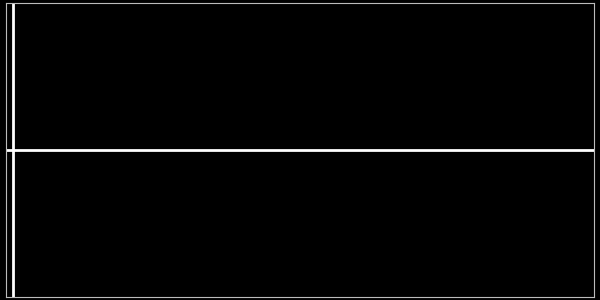

In [13]:
final_lesson = num_lessons + 1
test_controller = torch.load('models/controllers/controller_lesson_{}.pth'.format(final_lesson), weights_only = False)
truck = Truck(lesson = final_lesson, display = True)

In [15]:
num_jackknifes = 0
for test_seed in range(1, 21):
    with torch.no_grad():
        truck.reset(train_test = "test", test_seed = test_seed)
        i = 0
        while truck.valid():
            t1 = torch.tensor([truck.ϕ],dtype=torch.float32)
            state = truck.state()      
            t2 = torch.Tensor(state)
            state = torch.cat((t1,t2))
            ϕ = test_controller(state)
            truck.step(ϕ.item())
            truck.draw()
            i += 1
        x, y, θ0, trailer_x, trailer_y, θ1 = truck.state()  
        num_jackknifes += truck.is_jackknifed()
        print(f"Number of Steps: {i}")
        print(f"Is Jackknifed ? {truck.is_jackknifed()}")
        print(f"Trailer x: {trailer_x:.3f}, Trailer y: {trailer_y:.3f}")
        print()
print(f"Number of Jackknifes: {num_jackknifes}")

Number of Steps: 303
Is Jackknifed ? False
Trailer x: -0.090, Trailer y: 0.656

Number of Steps: 27
Is Jackknifed ? True
Trailer x: 16.004, Trailer y: -8.251

Number of Steps: 207
Is Jackknifed ? False
Trailer x: -0.025, Trailer y: 3.095

Number of Steps: 34
Is Jackknifed ? True
Trailer x: 20.904, Trailer y: 1.253

Number of Steps: 316
Is Jackknifed ? False
Trailer x: -0.057, Trailer y: 1.951

Number of Steps: 45
Is Jackknifed ? False
Trailer x: 22.787, Trailer y: -10.013

Number of Steps: 318
Is Jackknifed ? False
Trailer x: -0.051, Trailer y: 0.186

Number of Steps: 111
Is Jackknifed ? False
Trailer x: -0.072, Trailer y: 2.676

Number of Steps: 133
Is Jackknifed ? False
Trailer x: -0.044, Trailer y: 2.404

Number of Steps: 254
Is Jackknifed ? False
Trailer x: -0.092, Trailer y: 0.211

Number of Steps: 293
Is Jackknifed ? False
Trailer x: -0.020, Trailer y: 0.356

Number of Steps: 276
Is Jackknifed ? False
Trailer x: -0.049, Trailer y: 0.198

Number of Steps: 106
Is Jackknifed ? False